_L'objectif de ce notebook est de créer des modéles de prédiction en se basant sur les données d'ATP._

In [60]:
#chargement de librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
low_memory=False
from pylab import rcParams
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels


In [12]:
#modification des paramètres
rcParams['figure.figsize'] = 40, 20
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 35
HUGE_SIZE=60
plt.rc('font', size=SMALL_SIZE)         
plt.rc('axes', titlesize=SMALL_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)    
plt.rc('ytick', labelsize=MEDIUM_SIZE)    
plt.rc('legend', fontsize=BIGGER_SIZE)     
plt.rc('figure', titlesize=BIGGER_SIZE)  


# Défintion des fonctions

In [66]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [29]:
def CreateLags(data, MeterName, Lag):
    OwnLag=list(range(1,Lag+1))
    #set output for model
    Y = data[MeterName]
    X=data.drop(MeterName,axis=1)


    # is there a relevant autocorrelation for the signal to be predicted?
    if (len(OwnLag) > 0): # is own lags are to be considered
        Xauto = Y # copy of Y to use for shifting
        for lag in OwnLag:
            if lag == OwnLag[0]: # first lag in vector
                dataShift = pd.DataFrame(Xauto.shift(periods = OwnLag[0]).fillna(method='bfill')) # shift with the first lag to be considered
                dataShift.columns=[dataShift.columns[0] +str(lag) +' lag']
            else:
                dataShiftExtra=pd.DataFrame(Xauto.shift(lag).fillna(method='bfill'))
                dataShiftExtra.columns=[dataShiftExtra.columns[0] +str(lag) +' lag']
                dataShift = pd.concat([dataShift, dataShiftExtra], axis = 1) # concatenate to existing vector
                
        X = pd.concat([X,dataShift],axis=1)       
    return (X.iloc [Lag:-Lag,], Y.iloc [Lag:-Lag,])[0]

# Chargement des données

In [14]:
df_apt=pd.read_csv('ATP.csv',sep=',',decimal='.',low_memory=False)

In [15]:
df_apt['tourney_date']=pd.to_datetime(df_apt['tourney_date'],format='%Y%m%d',errors='coerce')

In [16]:
df_apt.index=df_apt['tourney_id']+df_apt['match_num']

In [17]:
print('nombre de observations:'+str(df_apt.shape[0])+ ' ; nombre de variables (features): '+str(df_apt.shape[1]))

nombre de observations:163966 ; nombre de variables (features): 49


# Analyse métier tennistique

_Pour commencer, j'ai éssayé de commprendre le métier en lisant les bonnes pratiques de tennis des passionnées et des experts de paris tennistique._
Afin de comprendre la partie métier, je me suis basé sur les sites suivants:

*https://www.omnisport.fr/parier-sur-le-tennis.html

*https://www.mediapronos.com/debuter/bien-parier-sur-le-tennis/

*https://www.pariez-gagnant.com/parier-sur-le-tennis/

Pour résumer, en se basant sur ces sites, pour bien parier sur le tennis nous devons nous baser sur :

*L’intérêt du tournoi POUR LE JOUEUR (chaque joueur a des ambitions différentes)

*L’état de santé du joueur (retour de blessure/pépin au match précédent)

*Le niveau moyen du joueur (dans un mauvais jour peut-il s’en sortir?)

*La confiance et le niveau actuel du joueur (une série de victoires/de défaites peut changer un joueur)

*Les schémas de jeux à utiliser pour parvenir à la victoire

*L’écart de niveau entre les 2 joueurs

*La gestion des moments importants

De plus, en se basant sur ces sites, pour mettre toutes les chances de notre côté, on doit optimiser nos paris en ne misant que sur les membres du Top 3, c’est-à-dire Novak Djokovic, Roger Federer et Rafael Nadal.

# Approche choisie

Pour ce faire, je vais implémenter un modèle de classification (ML) pour un membre (Roger Federer) du Top 3, en se basant sur approche historique (lags) pour prendre en considération l'état des joueurs tout en utilisant les variables explicatives pertinents ciblées dans la phase exploratoire.

## Selection ,traitement et transformation des données

In [18]:
df_apt_Player_winner=df_apt[(df_apt.winner_name=='Roger Federer')].copy()
df_apt_Player_winner['Target']=1
df_apt_Player_loser=df_apt[(df_apt.loser_name=='Roger Federer')].copy()
df_apt_Player_loser['Target']=0

In [19]:
df_apt_Player_winner.columns=['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'targeted_player_id', 'targeted_player_seed', 'targeted_player_entry',
       'targeted_player_name', 'targeted_player_hand', 'targeted_player_ht', 'targeted_player_ioc', 'targeted_player_age',
       'targeted_player_rank', 'targeted_player_rank_points', 'other_player_id', 'other_player_seed',
       'other_player_entry', 'other_player_name', 'other_player_hand', 'other_player_ht', 'other_player_ioc',
       'other_player_age', 'other_player_rank', 'other_player_rank_points', 'score', 'best_of',
       'round', 'minutes', 't_ace', 't_df', 't_svpt', 't_1stIn', 't_1stWon',
       't_2ndWon', 't_SvGms', 't_bpSaved', 't_bpFaced', 'O_ace', 'O_df',
       'O_svpt', 'O_1stIn', 'O_1stWon', 'O_2ndWon', 'O_SvGms', 'O_bpSaved',
       'O_bpFaced','Target']

In [20]:
df_apt_Player_loser.columns=['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'other_player_id', 'other_player_seed', 'other_player_entry',
       'other_player_name', 'other_player_hand', 'other_player_ht', 'other_player_ioc', 'other_player_age',
       'other_player_rank', 'other_player_rank_points', 'targeted_player_id', 'targeted_player_seed',
       'targeted_player_entry', 'targeted_player_name', 'targeted_player_hand', 'targeted_player_ht', 'targeted_player_ioc',
       'targeted_player_age', 'targeted_player_rank', 'targeted_player_rank_points', 'score', 'best_of',
       'round', 'minutes', 'O_ace', 'O_df', 'O_svpt', 'O_1stIn', 'O_1stWon',
       'O_2ndWon', 'O_SvGms', 'O_bpSaved', 'O_bpFaced', 't_ace', 't_df',
       't_svpt', 't_1stIn', 't_1stWon', 't_2ndWon', 't_SvGms', 't_bpSaved',
       't_bpFaced','Target']

In [21]:
df_apt_Player=pd.concat([df_apt_Player_winner,df_apt_Player_loser],axis=0,sort=True)

In [26]:
all_selected_features=['surface','draw_size','tourney_level','tourney_date',
                   'other_player_age','other_player_name','targeted_player_ht','other_player_ht','O_ace','t_ace',
                   'minutes', 'O_ace', 'O_df', 'O_svpt', 'O_1stIn', 'O_1stWon',
                    'O_2ndWon', 'O_SvGms', 'O_bpSaved', 'O_bpFaced', 't_ace', 't_df','t_svpt',
                   't_1stIn', 't_1stWon', 't_2ndWon', 't_SvGms', 't_bpSaved','t_bpFaced','other_player_rank',
                   'targeted_player_rank','other_player_rank_points','targeted_player_rank_points','round']

In [27]:
none_lag_features=[ 'surface', 'draw_size', 'tourney_level','tourney_date',
       'match_num', 'round',
       'other_player_name', 'other_player_hand', 'other_player_ht', 'other_player_ioc', 'other_player_age']

In [28]:
lag_features=list(set(all_selected_features)-set(none_lag_features))

In [30]:
df_final_part_1=df_apt_Player[none_lag_features].copy()

In [31]:
df_final_part_2=pd.DataFrame()

In [32]:
lag_features

['targeted_player_rank',
 't_svpt',
 'targeted_player_rank_points',
 'O_1stIn',
 'other_player_rank_points',
 't_1stWon',
 'O_SvGms',
 't_bpSaved',
 'O_ace',
 'targeted_player_ht',
 'O_bpSaved',
 't_SvGms',
 't_1stIn',
 't_df',
 't_ace',
 't_2ndWon',
 'minutes',
 'O_1stWon',
 'other_player_rank',
 'O_2ndWon',
 't_bpFaced',
 'O_bpFaced',
 'O_svpt',
 'O_df']

In [33]:
for feature in lag_features+['Target']:
    df_final_part_2=pd.concat([df_final_part_2,pd.DataFrame(CreateLags(df_apt_Player[[feature]],feature,4))],axis=1)

In [34]:
df_final_part_1.head()

,surface,draw_size,tourney_level,tourney_date,match_num,round,other_player_name,other_player_hand,other_player_ht,other_player_ioc,other_player_age
1998-327014,Hard,32,A,1998-09-28,014,R32,Guillaume Raoux,R,180,FRA,28.6187542779
1998-327023,Hard,32,A,1998-09-28,023,R16,Richard Fromberg,R,196,AUS,28.4188911704
1999-328010,Carpet,32,A,1999-10-04,010,R32,Martin Damm,R,188,CZE,27.1731690623
1999-328021,Carpet,32,A,1999-10-04,021,R16,Alexander Popp,R,201,GER,22.9130732375
1999-73009,Hard,32,A,1999-09-13,009,R32,Cedric Pioline,R,188,FRA,30.2450376454


In [35]:
df_final=pd.concat([df_final_part_1,df_final_part_2,df_apt_Player[['Target']]],axis=1,sort=True)

In [36]:
df_final['Year']=df_final['tourney_date'].dt.year
df_final['Day']=df_final['tourney_date'].dt.day
df_final['Month']=df_final['tourney_date'].dt.month

In [37]:
df_final=df_final.drop('tourney_date',axis=1)

In [38]:
df=df_final[['surface','tourney_level','other_player_name','other_player_hand','other_player_ioc','round']]
Input_data=pd.get_dummies(df, prefix=list(df.columns))

In [39]:
df_final=df_final.drop(['surface','tourney_level','other_player_name','other_player_hand','other_player_ioc','round'],axis=1).copy()

In [40]:
df_final=pd.concat([df_final,Input_data],axis=1)

In [41]:
df_final=df_final.dropna(axis=0)

In [42]:
df_final.shape

(1310, 496)

In [43]:
df_final.head()

,draw_size,match_num,other_player_ht,other_player_age,targeted_player_rank1 lag,targeted_player_rank2 lag,targeted_player_rank3 lag,targeted_player_rank4 lag,t_svpt1 lag,t_svpt2 lag,...,other_player_ioc_ZIM,round_BR,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
1998-314002,32,002,180,23.7316906229,396,878,17,17,53,67,...,0,0,0,0,0,0,1,0,0,0
1998-327028,32,028,183,28.4572210815,17,17,17,17,138,143,...,0,0,0,1,0,0,0,0,0,0
1998-328005,32,005,180,28.4353182752,878,17,17,17,67,138,...,0,0,0,0,0,0,1,0,0,0
1999-311009,56,009,175,29.6673511294,103,243,93,96,160,65,...,1,0,0,0,0,0,0,1,0,0
1999-314006,32,006,193,27.8110882957,702,396,878,17,74,53,...,0,0,0,0,0,0,1,0,0,0


In [44]:
# for col in df_final.columns: 
#     print(col)

# Modélisation

Préparation des données: on va utiliser la validation croisée et un partage aléatoire des données et un entrainement de données sur 33 % de l'ensemble afin d'éviter le surapprentissage des données (overfitting).

In [45]:
X = df_final.drop('Target', axis=1)
y = df_final['Target']

In [46]:
from sklearn.model_selection import train_test_split
# implementing train-test-split
train_features, X_test, train_labels, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

Création du modéle ( l'instanciation )

In [49]:
from sklearn.ensemble import RandomForestClassifier
# on commence par la création de modéle de base à tuner (optimiser)


In [50]:
rf = RandomForestClassifier()

Définition des hyperparamètres (pour les utiliser dans la phase d'optimisation (parameters tunning)

In [51]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [52]:
#On va utiliser random search afin de trouver la comibinaision optimale de paramètre
# une recherche aléatoire des paramétres, en utilisant 3 validations croisées,
# on va parcourrir 10 combinations en utilisant toutes les variables
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [53]:
# sauvagarder le modéle
filename = 'tennis_model.sav'
pickle.dump(rf_random, open(filename, 'wb'))



In [54]:
# Prédiction en utilisant l'ensemble de test
rfc_prediction = rf_random.predict(X_test)

# évaluation de la qualité du modèle (métriques de performance)

In [55]:
from sklearn.metrics import confusion_matrix


In [56]:
rfc_prediction

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

In [57]:
# calcul de la matrice de confusion
cnf_matrix = confusion_matrix(y_test, rfc_prediction)

In [62]:
df_confusion_matrix= pd.DataFrame(cnf_matrix)

Normalized confusion matrix
[[0.98717949 0.01282051]
 [0.         1.        ]]


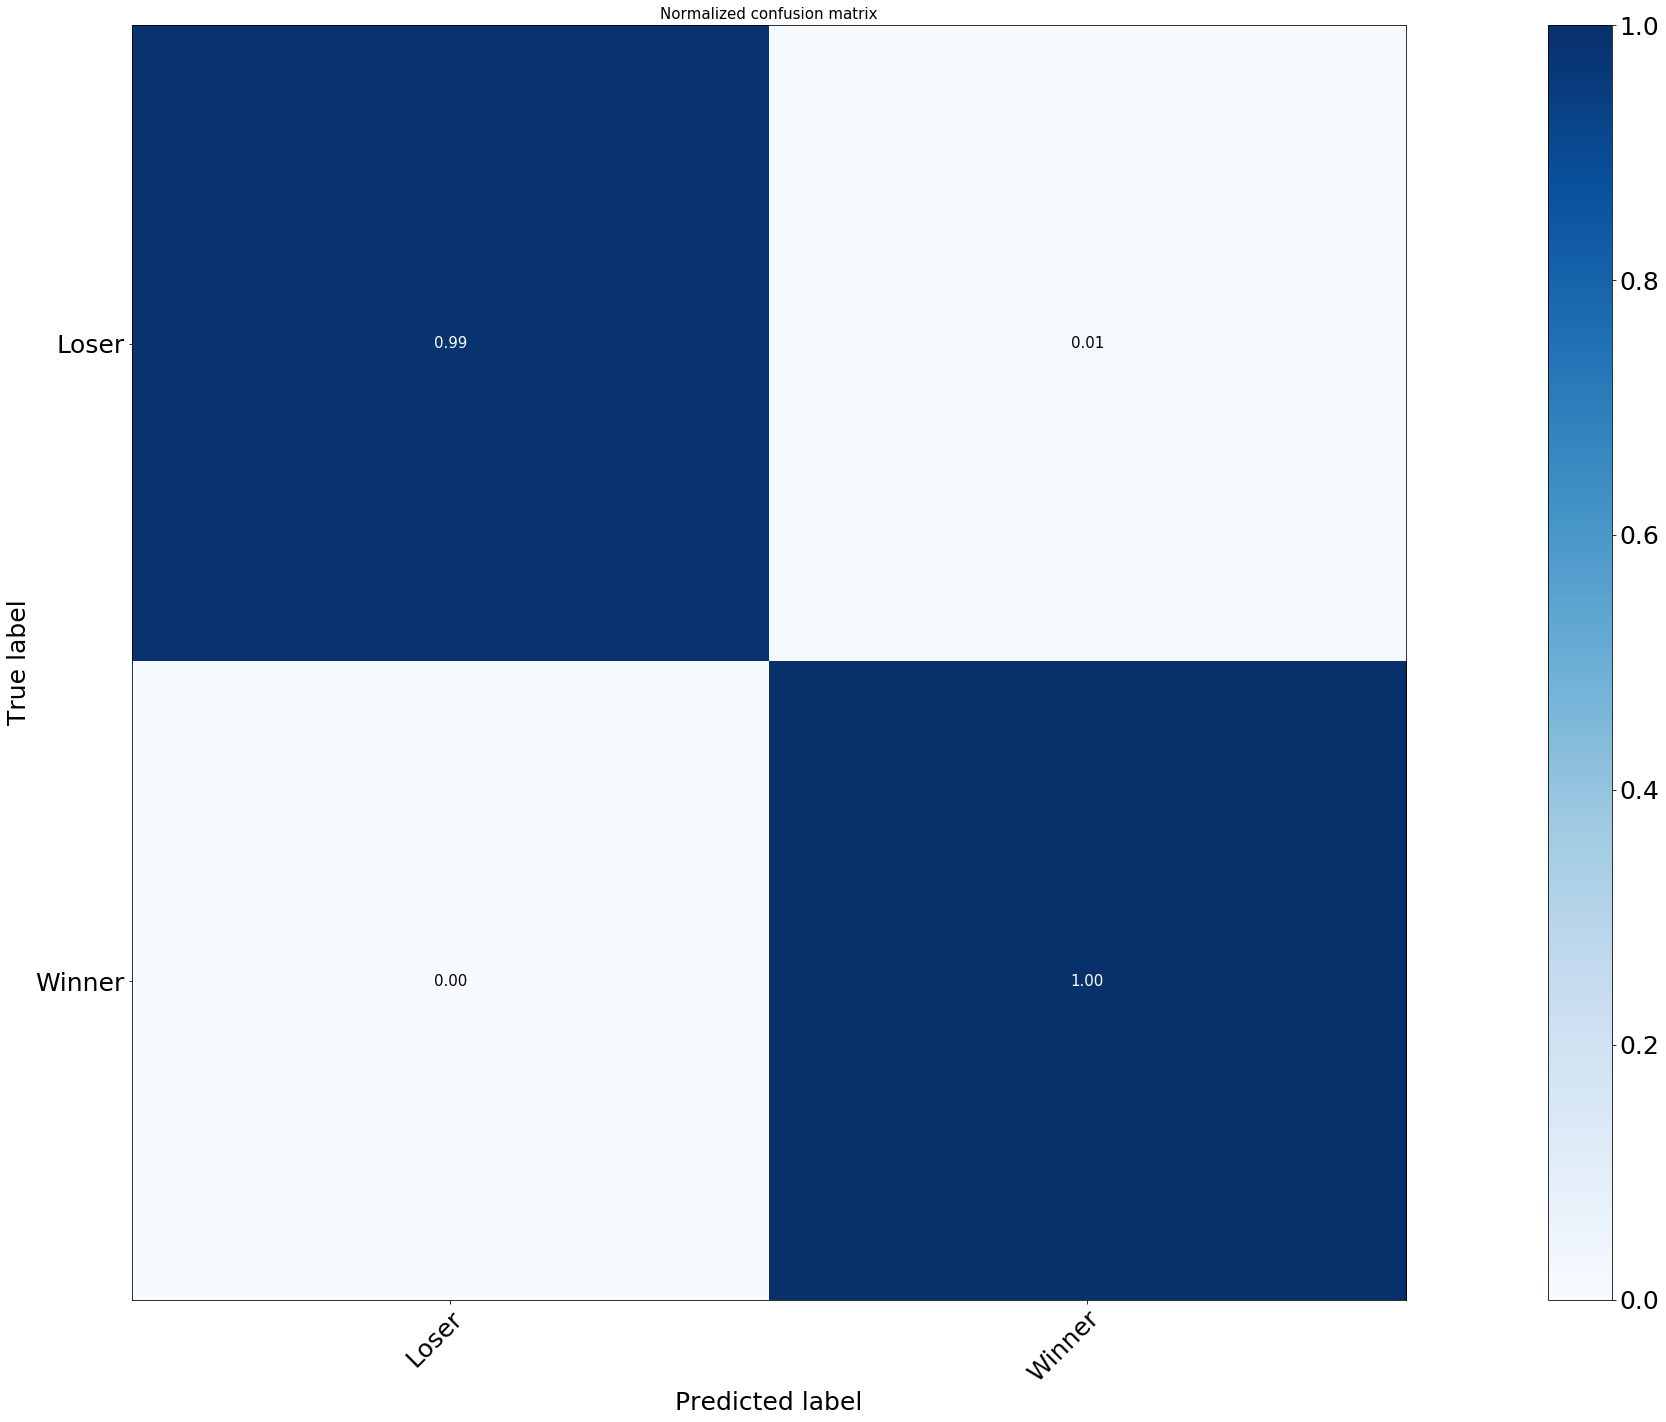

In [68]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, rfc_prediction, classes=['Loser','Winner'], normalize=True,
                      title='Normalized confusion matrix')

In [69]:
# calcul de la précision
from sklearn import metrics
print(metrics.accuracy_score(y_test, rfc_prediction))

0.9976905311778291
